In [333]:
# Pennylane
import pennylane as qml
from pennylane import numpy as np
from scipy.linalg import expm
# Plotting
import matplotlib.pyplot as plt

# Setting of the main hyper-parameters of the model

In [405]:
n_qubits = 1  # Number of system qubits.
n_shots = 10 ** 6  # Number of quantum measurements.

# Hyper-parameters for the HHL algorithm
phase_qubits = 4 # Number of qubits used for phase estimation.
ancilla_qubit = 1 # Number of ancillary qubits used for eigenvalue encoding amplitude
tot_qubits_HHL = n_qubits + phase_qubits + ancilla_qubit # Total number of qubits (system + ancillary + QPE qubits).

# Hybrid algorithm hyper-parameters
ancilla_idx = n_qubits  # Index of the one ancillary qubit (last position).
tot_qubits_VQLS = n_qubits + 1  # Total number of qubits (system + ancillary).
steps = 50  # Number of optimization steps
eta = 0.8  # Learning rate
rng_seed = 0  # Seed for random number generator
dim = 2 ** n_qubits  # Dimension of the problem space
epsilon = 1e-6  # threshold for convergence

In [ ]:
# For the HHL algorithm, we need to define the phase estimation wires and target wires.
# Assume phase_wires and target_wire are defined as in previous cells
phase_wires = range(phase_qubits)  # Phase estimation wires
target_wires = range(phase_qubits, phase_qubits + n_qubits)  # Target wires
ancilla_wires = range(phase_qubits + n_qubits, phase_qubits + n_qubits + ancilla_qubit)  # Ancilla wires

In [336]:
# Specified power injections (Sbus)
# Bus 1: Slack → value not used for mismatch (can set to 0)
# Bus 2: PQ bus with P=10 MW, Q=0
# Bus 3: PQ bus with P=-15 MW, Q=-5 MVAr
Sbus = [0+0j, 0.1+0j, -0.15-0.05j]

# Ybus matrix for 3-bus system (from the paper's example)
Ybus = np.array([
    [0 - 2j, 0 + 1j, 0 + 1j],
    [0 + 1j, 0 - 1.5j, 0 + 0.5j],
    [0 + 1j, 0 + 0.5j, 0 - 1.5j]
])

In [ ]:
B_prime = np.array([[-1.5, 0.5],
           [0.5, -1.5]], dtype=np.complex128)

B_double_prime = np.array([[-1.5, 0.5],
                  [0.5, -1.5]], dtype=np.complex128)
# These matrix need to be redefiend to be a positive deifined matrix

# HHL algorithm

In [338]:
def apply_unitary(A_matrix,wires):
    # Compute the unitary U = exp(iA)
    U = expm(1j * A_matrix)
    # Apply the unitary operation to the specified wires
    qml.QubitUnitary(U, wires=wires)

# Define the quantum phase estimation circuit
def qpe_circuit(A_matrix, phase_wires, target_wire): 
    # Initialize target in eigenstate of U
    # qml.Hadamard(wires=target_wire)

    # Apply Hadamards to phase register
    for w in phase_wires:
        qml.Hadamard(wires=w)

    # Apply controlled-U^{2^k}
    apply_unitary_powers = [2 ** i for i in range(len(phase_wires))]

    for i, power in enumerate(apply_unitary_powers):
        for _ in range(power):
            qml.ctrl(apply_unitary, control=phase_wires[::-1][i])(A_matrix = A_matrix,wires=target_wire)

    # Apply inverse QFT
    qml.adjoint(qml.QFT)(wires=phase_wires)

# Define the controlled fractional rotation operation
def AQE_fractional_rotation(control_wires, target_wire):
    """Apply controlled RY rotation based on fractional binary interpretation of control qubits."""
    n = len(control_wires)

    for d in range(1, 2**n):  # skip d=0 to avoid divide-by-zero
        # Convert decimal to binary string to run all possible state
        bin_str = f"{d:0{n}b}"
        # Convert binary string to list of bits for controlled rotation
        bit_strings = [int(bit) for bit in bin_str]
        # Compute fractional binary value: d = sum x_j * 2^-j
        fractional_d = sum(int(bit) * 2**-(j+1) for j, bit in enumerate(bin_str))
        # Compute the inverse of the fractional value
        inv = 1 / fractional_d
        # Normalize to [0, 1] range
        inv = inv / (2 ** n)
        # Convert to angle for RY gate, the state |0> amplitude corresponds to inv value
        theta = np.arccos(inv) * 2  # 2*theta for full RY
        # Apply controlled RY rotation on target wire controling on control wires
        qml.ctrl(qml.RY, control=control_wires, control_values=bit_strings)(theta,wires=target_wire)

In [339]:
dev = qml.device("default.qubit", wires=tot_qubits_HHL)
@qml.qnode(dev)
def hhl_circuit(A_matrix,vector):
    # 1. Initialize the target qubit
    # Normalize the input vector
    norm_vector = vector / np.linalg.norm(vector)
    # Initialize the quantum state to the normalized vector on the target wires
    qml.QubitStateVector(norm_vector, wires=target_wires)
    # for target_wire in target_wires:
    #     qml.Hadamard(wires=target_wire) # in this example, |b> = U_b |0> = H_0 H_1 ... |0>

    # 2. Apply QPE (Quantum Phase Estimation)
    qpe_circuit(A_matrix, phase_wires, target_wires)

    # 3. Apply AQE fractional rotation (controlled RY based on phase_wires)
    AQE_fractional_rotation(phase_wires, ancilla_wires)

    # 4. Apply inverse QPE (adjoint of QPE)
    qml.adjoint(qpe_circuit)(A_matrix, phase_wires, target_wires)

    # 5. Measure the target qubit
    probs = qml.probs(wires= [*target_wires,*ancilla_wires])
    return probs

def hhl_al(A_matrix, vector):
    probs = hhl_circuit(A_matrix, vector)
    #6. Get indices where ancilla qubit is 0 (i.e., even indices)
    ancil_position = tot_qubits_HHL - ancilla_wires[0] - 1  # Assuming ancilla_wires is a list with one element
    ancilla_zero_indices = [i for i in range(len(probs)) if (i & 2**ancil_position) == 0]
    # Filter probabilities where ancilla qubit is in |0>
    probs_ancilla0 = probs[ancilla_zero_indices]
    # Normalize the filtered probabilities ???
    probs_ancilla0_normalized = probs_ancilla0 / np.sum(probs_ancilla0) # * np.linalg.norm(vector)**2  
    
    return probs_ancilla0_normalized

# Variational quantum linear solver

In [367]:
def U_b(vector):
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    # Normalize the input vector
    norm_vector = vector / np.linalg.norm(vector)
    # Initialize the quantum state to the normalized vector on the target wires
    qml.QubitStateVector(norm_vector, wires=[i for i in range(n_qubits)])
    # for idx in range(n_qubits):
    #     qml.Hadamard(wires=idx)

def CA_gate(idx, ancilla_idx, hamiltonian):
    """Controlled versions of the unitary components A_idx of the problem matrix A."""
    if n_qubits == 1:
        if hamiltonian.ops[idx].name == 'Identity':
            return  # Idientity operation, do nothing
        elif hamiltonian.ops[idx].name == 'PauliX':
            qml.CNOT(wires=[ancilla_idx, 0]) # Apply X gate 
        elif hamiltonian.ops[idx].name == 'PauliZ':
            qml.CZ(wires=[ancilla_idx, 0]) # Apply Z gate
        elif hamiltonian.ops[idx].name == 'PauliY':
            qml.CY(wires=[ancilla_idx, 0]) # Apply Y gate
    else:
        for i in range(n_qubits):
            if hamiltonian.ops[idx][i].name == 'Identity':
                continue    # Idientity operation, do nothing
            elif hamiltonian.ops[idx][i].name == 'PauliX':
                qml.CNOT(wires=[ancilla_idx, i]) # Apply X gate 
            elif hamiltonian.ops[idx][i].name == 'PauliZ':
                qml.CZ(wires=[ancilla_idx, i]) # Apply Z gate
            elif hamiltonian.ops[idx][i].name == 'PauliY':
                qml.CY(wires=[ancilla_idx, i]) # Apply Y gate


In [375]:
def variational_block(weights):
    '''Variational block for the real amplitude ansatz, applying RY rotations and CNOTs in a linear entanglement pattern.'''
    depth = len(weights) // n_qubits

    param_index = 0
    for _ in range(depth):
        # Step 1: Apply RY rotations
        for i in range(n_qubits):
            qml.RY(weights[param_index], wires=i)
            param_index += 1

        # Step 2: Apply entangling CNOTs (linear)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])

In [376]:
dev_mu = qml.device("default.qubit", wires= tot_qubits_VQLS)
@qml.qnode(dev_mu, interface="autograd")
def local_hadamard_test(weights, l=None, lp=None, j=None, part=None):
    """Local Hadamard test for estimating the expectation value of a Hermitian operator."""
    # First Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # For estimating the imaginary part of the coefficient "lambda", we must add a "-i"
    # phase gate.
    if part == "Im" or part == "im":
        qml.PhaseShift(-np.pi / 2, wires=ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A.
    # CA(l) # Manual defined operators for specific A
    CA_gate(l, ancilla_idx, hamiltonian) # Generalized operators for a Hermitian A

    # Adjoint of the unitary U_b associated to the problem vector |b>.
    U_b(Init_vector) # In this specific example Adjoint(U_b) = U_b.

    # Controlled Z operator at position j. If j = -1, apply the identity.
    if j != -1:
        qml.CZ(wires=[ancilla_idx, j])

    # Unitary U_b associated to the problem vector |b>.
    U_b(Init_vector)

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoint(A_lp) = A_lp.
    # CA(lp) # Manual defined operators for specific A
    CA_gate(lp, ancilla_idx, hamiltonian) # Generalized operators for a Hermitian A
    
    # Second Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # Expectation value of Z for the ancillary qubit.
    return qml.expval(qml.PauliZ(wires=ancilla_idx))

def mu(weights, l=None, lp=None, j=None):
    """Generates the coefficients to compute the "local" cost function C_L."""

    mu_real = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Re")
    mu_imag = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Im")

    return mu_real + 1.0j * mu_imag

def psi_norm(weights):
    """Returns the normalization constant <psi|psi>, where |psi> = A |x>."""
    norm = 0.0

    for l in range(0, len(coupling)):
        for lp in range(0, len(coupling)):
            norm = norm + coupling[l] * np.conj(coupling[lp]) * mu(weights, l, lp, -1)

    return abs(norm)

def cost_loc(weights):
    """Local version of the cost function. Tends to zero when A|x> is proportional to |b>."""
    mu_sum = 0.0
    
    for l in range(0, len(coupling)):
        for lp in range(0, len(coupling)):
            for j in range(0, n_qubits):
                mu_sum = mu_sum + coupling[l] * np.conj(coupling[lp]) * mu(weights, l, lp, j)

    mu_sum = abs(mu_sum)

    # Cost function C_L
    return 0.5 - 0.5 * mu_sum / (n_qubits * psi_norm(weights))

In [398]:
def VQLS(init_weights, steps=steps, eta=eta):
    """Variational Quantum Linear Solver (VQLS) algorithm."""
    # Set the random seed
    np.random.seed(rng_seed)
    # Define the optimizer
    opt = qml.GradientDescentOptimizer(eta)
    # Variational optimization loop
    cost_history = []
    w = init_weights
    for it in range(steps):
        if cost_loc(w) > epsilon:  # Continue until cost is sufficiently low
            w, cost = opt.step_and_cost(cost_loc, w)
            print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost))
            cost_history.append(cost)
        else:
            break
    return w, cost_history

# Quantum Power Flow Algorithm

Where it is based on Fast Decouple Load Flow method

In [212]:
def CLS(matrix, vector):
    """Classical solver for linear equations."""
    A = np.array(matrix)
    b = np.array(vector)
    x = np.linalg.solve(A, b)
    return x.tolist()

In [213]:
def calc_mismatch(Vthe_slack,Vm, theta, Ybus, Sbus):
    """
    Calculate ΔP and ΔQ: power mismatches between specified and calculated values. 
    **!!This function computes for the PQ buses and 1 slack bus.
    
    Args:
        Vthe_slack (float): Voltage magnitude and angle of the slack bus (V, Θ)
        Vm (list): Voltage magnitudes [V2, V3, ..., Vn]
        theta (list): Voltage angles [Θ2, Θ3, ..., Θn] in radians
        Ybus (ndarray): n x n complex admittance matrix
        Sbus (list): Specified complex power injections [S1, S2, ..., Sn] (P + jQ)
        
    Returns:
        ΔP (list): Active power mismatch
        ΔQ (list): Reactive power mismatch
    """
    # Insert slack bus voltage and angle at the beginning of Vm and theta
    Vm = [Vthe_slack[0]] + list(Vm)
    theta = [Vthe_slack[1]] + list(theta)
    n = len(Vm)
    ΔP = []
    ΔQ = []
    # Loop through each bus
    for i in range(1,n):
        Pi_calc = 0
        Qi_calc = 0
        
        for k in range(n):
            Vi = Vm[i]
            Vk = Vm[k]
            θik = theta[k] - theta[i]
            Yik = Ybus[i, k]
            Gik = Yik.real
            Bik = Yik.imag
            # Power flow equations
            Pi_calc += Vi * Vk * (Gik * np.cos(θik) + Bik * np.sin(θik))
            Qi_calc += Vi * Vk * (Gik * np.sin(θik) - Bik * np.cos(θik))
        # Given power injections
        Pi_spec = Sbus[i].real
        Qi_spec = Sbus[i].imag
        # Calculate mismatches
        ΔP.append(Pi_spec - Pi_calc)
        ΔQ.append(Qi_spec - Qi_calc)

    return ΔP, ΔQ

In [347]:
def quantum_power_flow(Ybus, B_prime, B_double_prime, V0, Vthe_slack, Sbus, xi=1e-5, quantum_model ='HHL'):
    # Voltage magnitudes
    Vm_Q = V0.copy()  # For quantum model
    Vm_C = V0.copy()  # For classical model       
    # Initial angles (rad)
    theta_C = [0.0 for _ in V0] # For classical model
    theta_Q = [0.0 for _ in V0] # For quantum model
    # Negate B matrices for HHL, as HHL requires positive definite matrices
    B_prime = -np.array(B_prime)
    B_double_prime = -np.array(B_double_prime)
    # Calculate initial mismatches
    ΔP_C, ΔQ_C = calc_mismatch(Vthe_slack, Vm_C, theta_C, Ybus, Sbus) # For classical model
    ΔP_Q, ΔQ_Q = calc_mismatch(Vthe_slack, Vm_Q, theta_Q, Ybus, Sbus) # For quantum model
    print("Initial mismatches (Classical):", ΔP_C, ΔQ_C)    
    print("Initial mismatches (Quantum):", ΔP_Q, ΔQ_Q)
    # Iteratively solve until mismatches are within tolerance
    # xi is the convergence threshold   
    while np.linalg.norm(ΔP_C) >= xi or np.linalg.norm(ΔQ_C) >= xi:
        ΔP_C = np.array(ΔP_C)
        ΔQ_C = np.array(ΔQ_C) 
        ΔP_Q = np.array(ΔP_Q)
        ΔQ_Q = np.array(ΔQ_Q)
        Δθ_C  = CLS(B_prime, ΔP_C)
        ΔVm_C = CLS(B_double_prime, ΔQ_C)
        print("Classical model updates:", ΔVm_C, Δθ_C)
        
        # If quantum model is HHL, use the quantum circuit to solve for updates
        if quantum_model == 'HHL':
            # Use HHL circuit to solve for voltage angle and magnitude updates
            Δθ_Q = hhl_al(B_prime, ΔP_Q)
            sign_delta_theta = np.sign(CLS(B_prime, ΔP_Q))
            Δθ_Q = sign_delta_theta * Δθ_Q
            ΔVm_Q = hhl_al(B_double_prime, ΔQ_Q)
            sign_delta_Vm = np.sign(CLS(B_double_prime, ΔQ_Q))
            ΔVm_Q = sign_delta_Vm * ΔVm_Q
            print("Quantum model updates:", ΔVm_Q, Δθ_Q)
        # Update values
        # Classical model updates
        Vm_C = [Vm_C[i] + ΔVm_C[i] for i in range(len(Vm_C))]
        theta_C = [theta_C[i] + Δθ_C[i] for i in range(len(theta_C))]
        # Quantum model updates
        Vm_Q = [Vm_Q[i] + ΔVm_Q[i] for i in range(len(Vm_Q))]
        theta_Q = [theta_Q[i] + Δθ_Q[i] for i in range(len(theta_Q))]
    
        
        # Recalculate mismatches
        ΔP_C, ΔQ_C = calc_mismatch(Vthe_slack, Vm_C, theta_C, Ybus, Sbus)
        ΔP_Q, ΔQ_Q = calc_mismatch(Vthe_slack, Vm_Q, theta_Q, Ybus, Sbus)

    # Return final voltage magnitudes and angles for both models
    # Vm_C, theta_C for classical model
    # Vm_Q, theta_Q for quantum model
    return Vm_C, theta_C, Vm_Q, theta_Q


In [352]:
Vm0 = [1, 1]
Vthe_slack = [1.03, 0.0]  # Slack bus voltage magnitude and angle (V, Θ)

Vm_C, theta_C, Vm_Q, theta_Q = quantum_power_flow(Ybus=Ybus, B_prime=B_prime, B_double_prime=B_double_prime,
                               V0=Vm0, Vthe_slack=Vthe_slack, Sbus=Sbus, xi=1e-5)

print("Voltage magnitudes (classical):", Vm_C)
print("Voltage angles (classical):", theta_C)
print("Voltage magnitudes (quantum):", Vm_Q)
print("Voltage angles (quantum):", theta_Q)

Initial mismatches (Classical): [tensor(0.1, requires_grad=True), tensor(-0.15, requires_grad=True)] [tensor(0.03, requires_grad=True), tensor(-0.02, requires_grad=True)]
Initial mismatches (Quantum): [tensor(0.1, requires_grad=True), tensor(-0.15, requires_grad=True)] [tensor(0.03, requires_grad=True), tensor(-0.02, requires_grad=True)]
Classical model updates: [(0.017500000000000022+0j), (-0.0074999999999999754+0j)] [(0.037500000000000006+0j), (-0.0875+0j)]
Quantum model updates: [ 0.8220759+0.j -0.1779241+0.j] [ 0.1779241+0.j -0.8220759+0.j]
Classical model updates: [(-0.005563745765034201+0j), (-0.007338292797754022+0j)] [(0.07611133316895426+0j), (-0.17615457163428294+0j)]
Quantum model updates: [-0.81463059+0.j -0.18536941+0.j] [ 0.25805202+0.j -0.74194798+0.j]
Classical model updates: [(-0.04347021796732238+0j), (-0.0563280871277858+0j)] [(0.1518213703060315+0j), (-0.34810535961809197+0j)]
Quantum model updates: [-0.48111737+0.j -0.51888263+0.j] [ 0.25578071+0.j -0.74421929+0.j]

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pennylane\numpy\tensor.py:155: RuntimeWarning: invalid value encountered in multiply
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)



### ?? got stuck on the how to extract the sign and true value of solution vector from the normalized distribution

# Comparing Linear Solver Methods

## VQSL running

In [406]:
# Example: 2-qubit Hermitian matrix
A = B_double_prime
Init_vector = np.array([0.03,-0.02])   # Vector Initial state |b>
# Ensure it's Hermitian
assert np.allclose(A, A.conj().T)
# Decompose the Hermitian matrix into Pauli operators
hamiltonian = qml.pauli_decompose(A)
# Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 ...
coupling = hamiltonian.coeffs
layers_ansatz = 3  # Number of layers in the ansatz
# Initialize the quantum weights
init_weights = 0.01 * np.random.randn(n_qubits * layers_ansatz, requires_grad=True)

In [407]:
# Prepare a new quantum device for sampling define the associated qnode circuit
dev_x = qml.device("default.qubit", wires=tot_qubits_VQLS)

@qml.qnode(dev_x, interface="autograd")
def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.probs(wires=range(n_qubits)) 
    # return qml.sample() 

In [408]:
w, cost_history = VQLS(init_weights, steps=steps, eta=eta)
# Generate the quantum state |x> and sample it
# Using the variational weights w that we have previously optimized.
probs_VQLS = prepare_and_sample(w)
print("Quantum probabilities for VQLS:", probs_VQLS)

Step   0       Cost_L = 0.0758124
Step   1       Cost_L = 0.0090211
Step   2       Cost_L = 0.0027078
Step   3       Cost_L = 0.0009316
Step   4       Cost_L = 0.0003400
Step   5       Cost_L = 0.0001279
Step   6       Cost_L = 0.0000490
Step   7       Cost_L = 0.0000189
Step   8       Cost_L = 0.0000074
Step   9       Cost_L = 0.0000029
Step  10       Cost_L = 0.0000011
Quantum probabilities for VQLS: [0.84568857 0.15431143]


<!-- ## HHL running -->

## HHL running

In [353]:
B_double_prime_HHL = -np.array(B_double_prime)

In [354]:
probs_HHL = hhl_al(B_double_prime_HHL, Init_vector)
print("Quantum probabilities from HHL:", probs_HHL)

Quantum probabilities from HHL: [0.8220759 0.1779241]


## Classical running

In [409]:
probs_cl = CLS(B_double_prime, Init_vector)
# In order to compare x with the quantum state |x>, we normalize and square its elements.
probs_cl = (probs_cl / np.linalg.norm(probs_cl)) ** 2
print("Classical probabilities:", probs_cl)

Classical probabilities: [0.84482759-0.j 0.15517241+0.j]


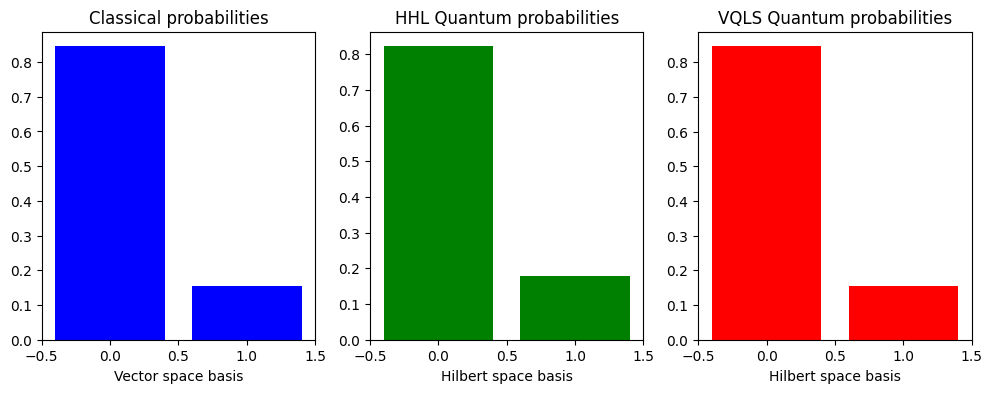

In [414]:
# Graphically visualize both distributions.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), probs_cl, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), probs_HHL, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("HHL Quantum probabilities")

ax3.bar(np.arange(0, 2 ** n_qubits), probs_VQLS, color="red")
ax3.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax3.set_xlabel("Hilbert space basis")
ax3.set_title("VQLS Quantum probabilities")

plt.show()